In [1]:
import io
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from matplotlib import rc
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler,RobustScaler # for standardizing the Data
from sklearn.decomposition import PCA

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

In [2]:
covid19_csv = pd.read_csv('owid-covid-data.csv')

covid19_csv.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [3]:
covid19_df = covid19_csv[['location','date','total_cases','new_cases','total_deaths','new_deaths','population','population_density','aged_65_older','gdp_per_capita','cardiovasc_death_rate','diabetes_prevalence','life_expectancy']]
covid19_df.head()

,location,date,total_cases,new_cases,total_deaths,new_deaths,population,population_density,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy
0,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
1,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
2,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
3,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
4,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83


In [4]:
# Converting the normally indexed dataframe to a time series indexed dataframe
covid19_df.index = pd.to_datetime(covid19_df['date'])
covid19_df = covid19_df.drop(columns=['date'])
covid19_df.head()

,location,total_cases,new_cases,total_deaths,new_deaths,population,population_density,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy
date,,,,,,,,,,,,
2019-12-31,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
2020-01-01,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
2020-01-02,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
2020-01-03,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
2020-01-04,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83


In [5]:
# Creating a new dataframe per country
grouped = covid19_df.groupby(covid19_df.location)


df_canada = grouped.get_group("Canada")
df_china = grouped.get_group("China")
df_italy = grouped.get_group("Italy")
df_mexico= grouped.get_group("Mexico")
df_finlad = grouped.get_group("Finland")
df_world = grouped.get_group("World")

df_all_selected_countries = covid19_df[covid19_df['location'].isin(['Canada','China','Italy','Mexico','Finland'])]

In [6]:
def dim_red(df):
  df = df.drop(columns=["location"])
  df = df.dropna( axis=1, how="any", thresh=None, subset=None, inplace=False)
    
  X = df.values # getting all values as a matrix of dataframe 
  sc = StandardScaler() # creating a StandardScaler object
  X_std = sc.fit_transform(X) # standardizing the data

  #PCA
  pca = PCA()
  X_pca = pca.fit(X_std)
  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.xlabel('number of components')
  plt.ylabel('cumulative explained variance');
  plt.show()

  #Dimensionality Reduction
  num_components = 3
  pca = PCA(num_components)  
  X_pca = pca.fit_transform(X_std)
  pca = PCA(n_components = 0.999)
  X_pca = pca.fit_transform(X_std) # this will fit and reduce dimensions
  print(pca.n_components_) # one can print and see how many components are selected. In this case it is 4 same as above we saw in step 5
  pd.DataFrame(pca.components_, columns = df.columns)

  n_pcs = pca.n_components_ # get number of component
  # get the index of the most important feature on EACH component
  most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
  initial_feature_names = df.columns
  # get the most important feature names
  most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

  return most_important_names



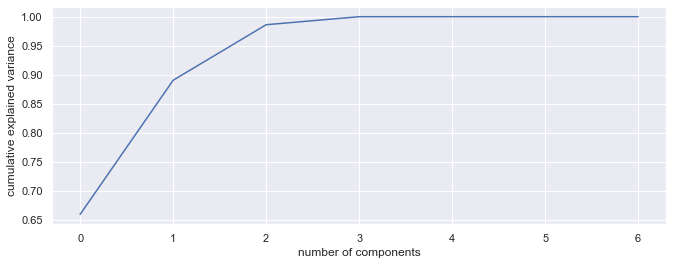

4
['gdp_per_capita', 'population_density', 'population_density', 'population']


In [8]:
#PCA Dimension reduction
important_parameters = dim_red(df_all_selected_countries)
print(important_parameters)

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [9]:
def predict_new_deaths(df):
  train_size = int(len(df) * 0.9)
  test_size = len(df) - train_size
  train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
  print(len(train), len(test))

  f_columns = ['population_density', 'aged_65_older', 'hospital_beds_per_100k', 'new_cases','new_deaths']

  f_transformer = RobustScaler()
  cnt_transformer = RobustScaler()

  f_transformer = f_transformer.fit(train[f_columns].to_numpy())
  cnt_transformer = cnt_transformer.fit(train[['new_deaths']])

  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
  train['cnt'] = cnt_transformer.transform(train[['new_deaths']])

  test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
  test['cnt'] = cnt_transformer.transform(test[['new_deaths']])

  def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

  time_steps = 10

  # reshape to [samples, time_steps, n_features]

  X_train, y_train = create_dataset(train, train.cnt, time_steps)
  X_test, y_test = create_dataset(test, test.cnt, time_steps)

  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128, 
        input_shape=(X_train.shape[1], X_train.shape[2])
      )
    )
  )
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=5, 
    validation_split=0.1,
    shuffle=False
  )

 

  y_pred = model.predict(X_test)

  y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
  y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
  y_pred_inv = cnt_transformer.inverse_transform(y_pred)

  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend();

  plt.show()

  plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
  plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
  plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
  plt.ylabel('Deaths per day')
  plt.xlabel('Time Step')
  plt.legend()
  plt.show();

In [10]:
def analyze(df,country):  

  sns.set(rc={'figure.figsize':(11, 4)})
  print(country)
  df['total_cases'].plot()
  #df['total_deaths'].plot()
  plt.show()
  df['new_cases'].plot()
  df['new_deaths'].plot()
  plt.show()
  #predict_daily_cases(df)
  df = df[['population_density', 'aged_65_older', 'hospital_beds_per_100k', 'new_cases','new_deaths']]
  predict_new_deaths(df)

MEXICO


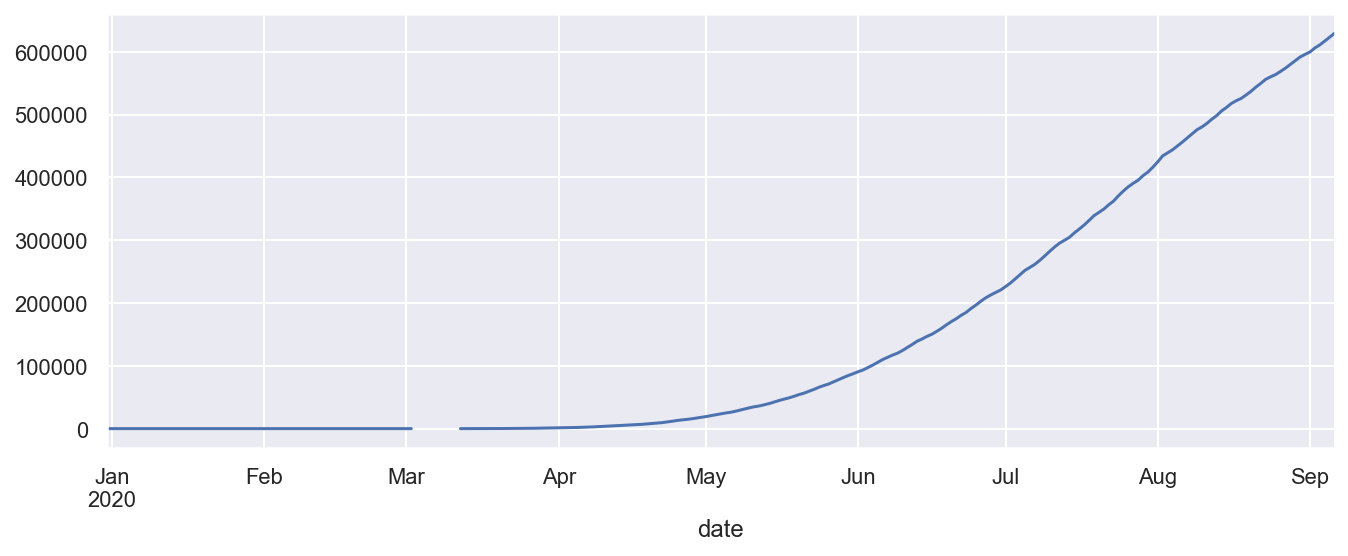

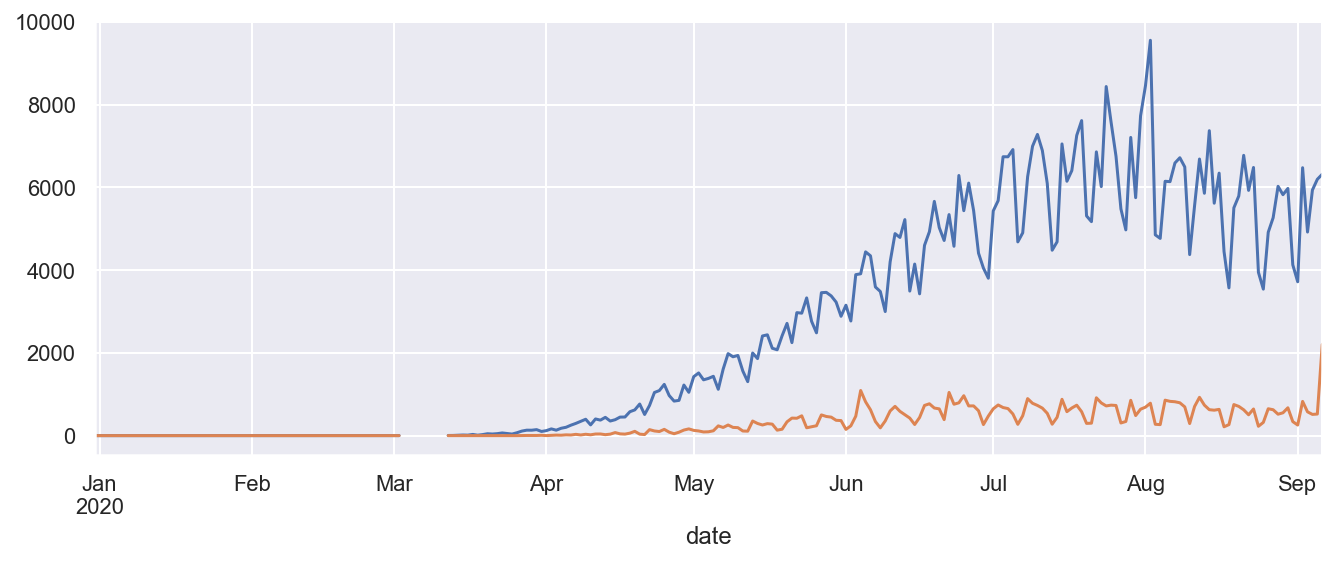

KeyError: "['hospital_beds_per_100k'] not in index"

In [11]:
analyze(df_mexico ,"MEXICO")